In [15]:
import numpy as np
from numpy import float32
import pandas as pd
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.time import parse_time
from astropy.io import fits
from astropy.time import Time
import matplotlib.patches as pac
import math
import matplotlib.image as mpimg
from PIL import Image
import os
import shutil
import math
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import cv2
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from utils import *

In [2]:
pd.options.display.max_columns = None

In [3]:
ALL_FLARE_EVENTS_CSV = './all_flares.csv'
AIA_DATA_DIR = './data'
HMI_DATA_DIR = './hmi_data'
EVENTS_BY_DATE_DIR = './cfd_events_by_date'
LSTM_FLARE_START_DATA_DIR = './LSTM_data/flare_start_prediction'
LSTM_FLARE_START_TRAIN_POSITIVE_DIR = './LSTM_data/flare_start_prediction/train/positive'
LSTM_FLARE_START_TRAIN_NEGATIVE_DIR = './LSTM_data/flare_start_prediction/train/negative'
LSTM_FLARE_START_TEST_DIR = './LSTM_data/flare_start_prediction/test/'

In [4]:
CDELT = 0.599733;
HPCCENTER = 4096.0 / 2.0;
rsun_meters = 696000;
dsun_meters = 149600000;
DEFAULT_WIDTH, DEFAULT_HEIGHT = 64, 64
IMAGE_WIDTH, IMAGE_HEIGHT = 512, 512

In [5]:
# returns a formatted file name of the closest AIA data file to the given datetime

def GetClosestDataFileByDate(dt, rounding):
    AIA_data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    tmp_dt = dt
    minute = 0
    
    if(rounding == "down"):
        minute = GetClosestMultipleDown(dt.minute, 6)
    elif(rounding == "up"):
        minute = GetClosestMultipleUp(dt.minute, 6)
    
    if(minute == 60):
        tmp_dt = tmp_dt + datetime.timedelta(hours=1)
        minute = 0
    
    AIA_data_time = f'{dt.hour:02d}{minute:02d}'
    AIA_data_filename = f'AIA{AIA_data_date}_{AIA_data_time}_0094.npz'
    
    return AIA_data_filename

In [6]:
# returns an NxN cutout of an AIA image array centered around the given coordinate

def GetCutout(im, coord, N=64):
    x_end_idx = int(coord[0]+N)
    y_end_idx = int(coord[1]+N)
    cutout_array = im[int(coord[0]):x_end_idx, int(coord[1]):y_end_idx]
    
    return cutout_array

In [7]:
# returns an NxN cutout of a file centered around the given coordinate

def GetFileCutout(path, coord, N=64):
    im = np.load(path)['x']
    
    return GetCutout(im, coord, N)

In [8]:
# returns an AIA filepath closest to the provided

def GetAIAPathAtTime(dt):
    dt_data_dir = os.path.join(AIA_DATA_DIR, f'{dt.year}/{dt.month:02d}/{dt.day:02d}')
    closest_data_file = GetClosestDataFileByDate(dt, "down")
    file_path = os.path.join(dt_data_dir, closest_data_file)
    if not os.path.exists(file_path):
        raise FileNotFoundError
        return
    
    return file_path

In [9]:
# returns M consecutive (forward or backward) AIA filepaths starting at time closest to the given time

def GetAIANCutoutsPaths(start_dt, direction='backward', M=6, cadence=6):
    cutouts_paths = []
    dynamic_dt = start_dt
    if direction == 'backward':
        cadence = -cadence
        
    for i in range(M):
        cutout = None
        try:
            cutout_path = GetAIAPathAtTime(dynamic_dt)
        except FileNotFoundError:
            M += 1
            dynamic_dt = dynamic_dt + datetime.timedelta(minutes=cadence)
            continue
        dynamic_dt = dynamic_dt + datetime.timedelta(minutes=cadence)
        cutouts_paths.append(cutout_path)
    
    return np.array(cutouts_paths)

In [10]:
# saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIANPositiveCutoutsFromCSV(csv_path, save_dir, direction='backward', flare_class='all'):
    df = pd.read_csv(csv_path)
    
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        coord = ConvertHPCToPixXY((x, y))
        coord = RefactorCoord(coord)
        cutouts_paths = GetAIANCutoutsPaths(start_dt, direction=direction)
        cutouts_folder = os.path.join(save_dir, raw_time.fits)
        if len(cutouts_paths) == 0:
            continue
        if not os.path.exists(cutouts_folder):
            os.makedirs(cutouts_folder)
        for c_path in cutouts_paths:
            c = GetFileCutout(c_path, coord)
            save_filename = os.path.basename(c_path).rsplit('.', 1)[0]
            np.save(f'{cutouts_folder}/{save_filename}', c)

In [18]:
# saves directional sequences of NxN cutouts of negative events for each event in the csv file to folders with start times as names

def SaveAIANNegativeCutoutsFromCSV(csv_path, save_dir, direction='backward', flare_class='all'):
    df = pd.read_csv(csv_path)
    
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        coord = ConvertHPCToPixXY((x, y))
        coord = RefactorCoord(coord)
        negative_dt = start_dt - datetime.timedelta(minutes=36)
        cutouts_paths = GetAIANCutoutsPaths(negative_dt, direction=direction)
        cutouts_folder = os.path.join(save_dir, raw_time.fits)
        if len(cutouts_paths) == 0:
            continue
        if not os.path.exists(cutouts_folder):
            os.makedirs(cutouts_folder)
        for c_path in cutouts_paths:
            c = GetFileCutout(c_path, coord)
            save_filename = os.path.basename(c_path).rsplit('.', 1)[0]
            np.save(f'{cutouts_folder}/{save_filename}', c)

In [12]:
# SaveAIANCutoutsFromCSV('./cfd_events_by_date/2016/1.csv', 'LSTM_data/flare_start_prediction/train/positive')

In [19]:
for year in range(2010, 2018):
    for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
        for f in files:
            fulldir = os.path.join(subdir, f)
            SaveAIANPositiveCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/B/positive', direction='backward', flare_class='B')

    for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
        for f in files:
            fulldir = os.path.join(subdir, f)
            SaveAIANNegativeCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/B/negative', direction='backward', flare_class='B')

In [20]:
for year in range(2010, 2018):
    for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
        for f in files:
            fulldir = os.path.join(subdir, f)
            SaveAIANPositiveCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/train/positive', direction='backward', flare_class='all')

    for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
        for f in files:
            fulldir = os.path.join(subdir, f)
            SaveAIANNegativeCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/train/negative', direction='backward', flare_class='all')

In [16]:
# for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/2014'):
#     for f in files:
#         fulldir = os.path.join(subdir, f)
#         SaveAIANPositiveCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/test/B/positive', direction='backward', flare_class='B')

# for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/2014'):
#     for f in files:
#         fulldir = os.path.join(subdir, f)
#         SaveAIANNegativeCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/test/B/negative', direction='backward', flare_class='B')

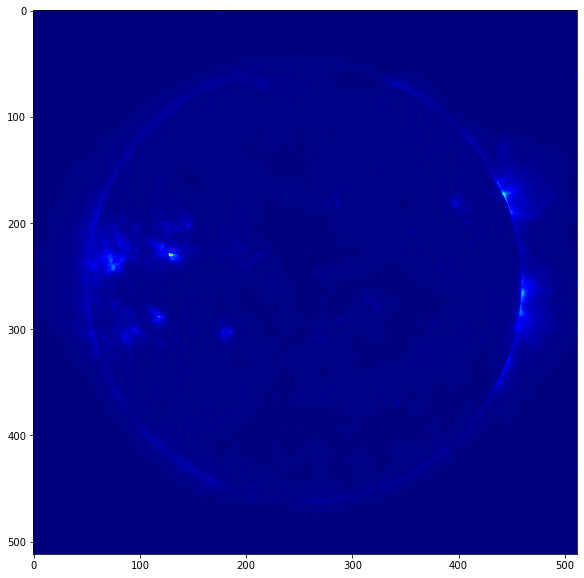

In [14]:
t = np.load('./data/2016/01/03/AIA20160103_2018_0094.npz')['x']
plt.figure(figsize=(10, 10))
plt.imshow(t, cmap='jet')

['./LSTM_data/flare_start_prediction/train/positive/2016-01-03T20:20:00/AIA20160103_2018_0094.npy', './LSTM_data/flare_start_prediction/train/positive/2016-01-03T20:20:00/AIA20160103_2012_0094.npy', './LSTM_data/flare_start_prediction/train/positive/2016-01-03T20:20:00/AIA20160103_2006_0094.npy', './LSTM_data/flare_start_prediction/train/positive/2016-01-03T20:20:00/AIA20160103_2000_0094.npy', './LSTM_data/flare_start_prediction/train/positive/2016-01-03T20:20:00/AIA20160103_1954_0094.npy', './LSTM_data/flare_start_prediction/train/positive/2016-01-03T20:20:00/AIA20160103_1948_0094.npy']


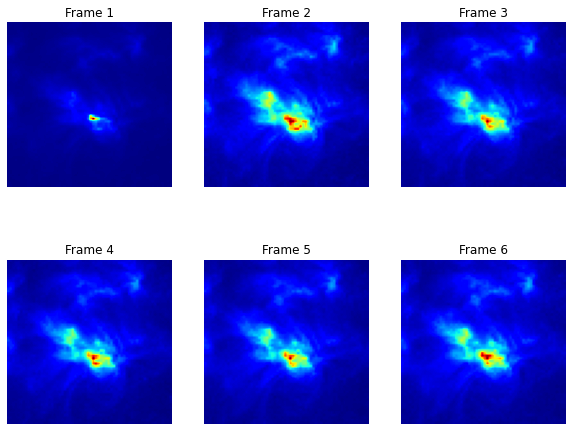

In [27]:
directory = os.path.join(LSTM_FLARE_START_TRAIN_POSITIVE_DIR, '2016-01-03T20:20:00')
paths = []
for subdir, dirs, files in os.walk(directory):
    for f in files:
        paths.append(os.path.join(subdir, f))

paths = sorted(paths, reverse=True)
print(paths)
        
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(np.load(paths[idx])), cmap="jet")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()